## Task: Solve a Multiclass Classification Problem Using NumPy Only

Implement a **Logistic Regression** using **Gradient Descent with L1 and L2 regularization**.

### Goal:
Achieve **F1-macro $> 0.95 $** on the provided dataset.


### Hints:
- Try different scalers.
- Experiment with **periodic** and **polynomial** features.


Clear memory

In [1331]:
%reset -f
import gc
gc.collect()

0

### Import libraries

In [1332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, time, json
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)  # количество отображаемых полей
pd.set_option('display.max_rows', None)  # количество отображаемых строк
warnings.simplefilter('ignore', category=FutureWarning)  # отключаем бесячие предупреждения
warnings.simplefilter('ignore', category=DeprecationWarning)  # отключаем бесячие предупреждения
%matplotlib inline

# Load Multi Classification dataset

In [1333]:
df = pd.read_csv('Multiclass_Classification_Dataset.csv', encoding='utf-8')

In [1334]:
df.head()

,x1,x2,x3,target
0,1.021706,1.226857,3.004102,3
1,-1.519710,-1.249860,-1.213463,2
2,-2.392225,-1.532171,2.041761,0
3,0.125801,-1.366283,0.149077,0
4,1.534612,2.141388,3.682540,3


Check the shape of the dataset

In [1335]:
df.shape

(1000, 4)

Check the main info about dataset

In [1336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   float64
 3   target  1000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


Check some stats

In [1337]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,1000.0,0.009486,1.620364,-4.450596,-1.453959,0.233930,1.445834,3.360860
x2,1000.0,-0.751864,1.571900,-4.337231,-1.808776,-1.202489,0.224259,5.119524
x3,1000.0,0.732060,1.595817,-4.278978,-0.181916,1.053498,1.866559,4.341188
target,1000.0,1.497000,1.116798,0.000000,0.750000,1.000000,2.000000,3.000000


Check missing values

In [1338]:
df.isna().sum()

x1        0
x2        0
x3        0
target    0
dtype: int64

There is no missing values in the dataset!

Check for percentage of duplicated samples

In [1339]:
df.duplicated().sum()/df.shape[0]*100

0.0

Check number of unique values of each variable

In [1340]:
df.nunique()

x1        1000
x2        1000
x3        1000
target       4
dtype: int64

The target is categorical, while all features are numerical

Define categorical and numerical features

In [1341]:
num_features = ['x1', 'x2', 'x3']

Define target variable

In [1342]:
target = 'target'
target_classes = df[target].nunique()

## Deleting outliers

We can use standart IQR

In [1343]:
def remove_outliers(df:pd.DataFrame, numeric_features) -> pd.DataFrame:

    mask = np.ones(df.shape[0], dtype=bool)

    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask &= (df[feature] >= lower_bound) & (df[feature] <= upper_bound)

    return df.loc[mask]

Create auxiliary dataframe

In [1344]:
df_copy = df.copy()

Since target is categorical, it is better to filter outliers inside each category

In [1345]:
df = df.groupby(target, group_keys=False).apply(remove_outliers, num_features)
df = pd.DataFrame(df)  # Auxiliary action. Corrects the code highlighting issue

Check that target distribution didn't change dramatically after filtering outliers

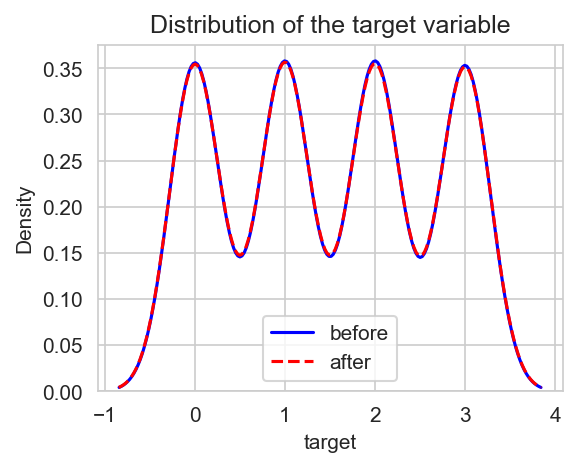

In [1346]:
plt.figure(figsize=(4,3), dpi=150)
sns.kdeplot(data=df_copy, x=target, label='before', color='blue')
sns.kdeplot(data=df, x=target, label='after', color='red', linestyle='--')
plt.legend()
plt.title('Distribution of the target variable')
plt.show()

Delete auxiliary variable to clear memory

In [1347]:
del df_copy

## EDA

### Single variable analysis

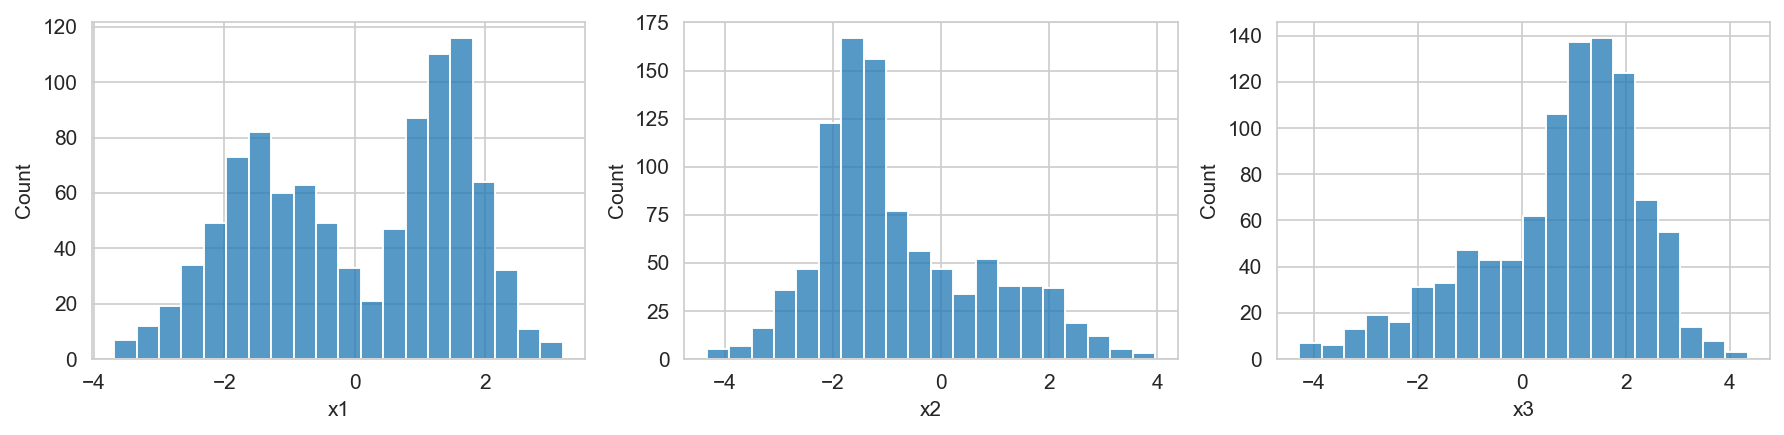

In [1348]:
plt.figure(figsize=(12,3), dpi=150)

for i,f in enumerate(num_features):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df, x=f, bins=20)

plt.tight_layout()
plt.show()

**Observations**: features are normally distributed, but they are skewed

Now, let's plot the distribution of the target

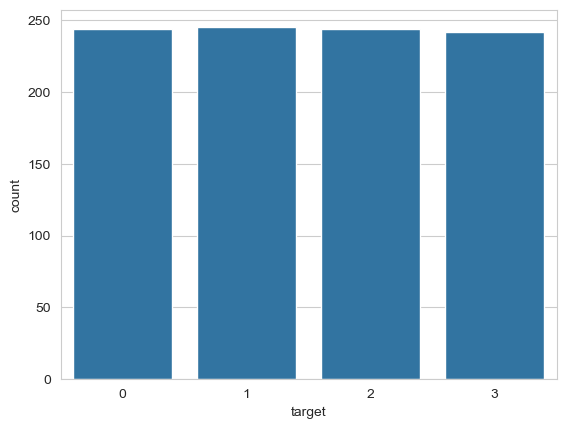

In [1349]:
sns.countplot(data=df, x=target)
plt.show()

Target classes are balanced very well

### Multivariable analysis

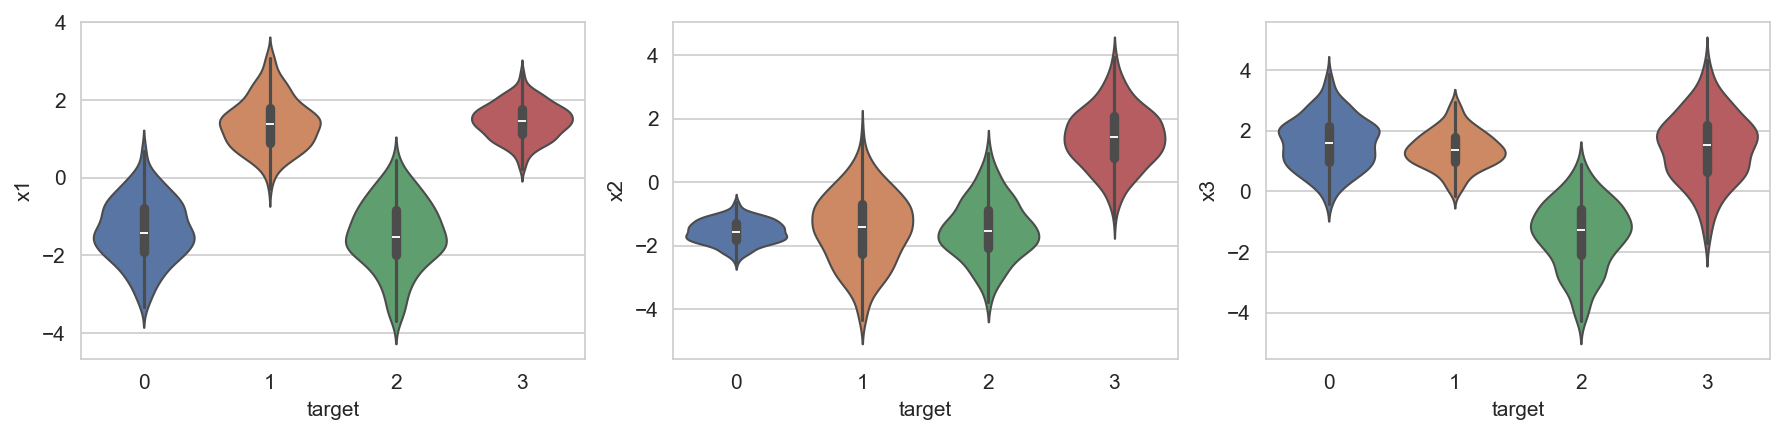

In [1350]:
plt.figure(figsize=(12,3), dpi=150)

for i,f in enumerate(num_features):
    plt.subplot(1,3,i+1)
    sns.violinplot(
        data=df,
        x=target,
        y=f,
        palette='deep',
        hue=target,
        legend=False,
        linewidth=1,
        alpha=1,
        inner='box',
        orient='v',
    )

plt.tight_layout()
plt.show()

**Observations:** 
1. X1 has sinusoidal trend with the target variable (class number)
2. X2 has nonlinear (polynomial) trend with the target variable (class number)
3. X3 has also nonlinear trend (looks similar to X1)

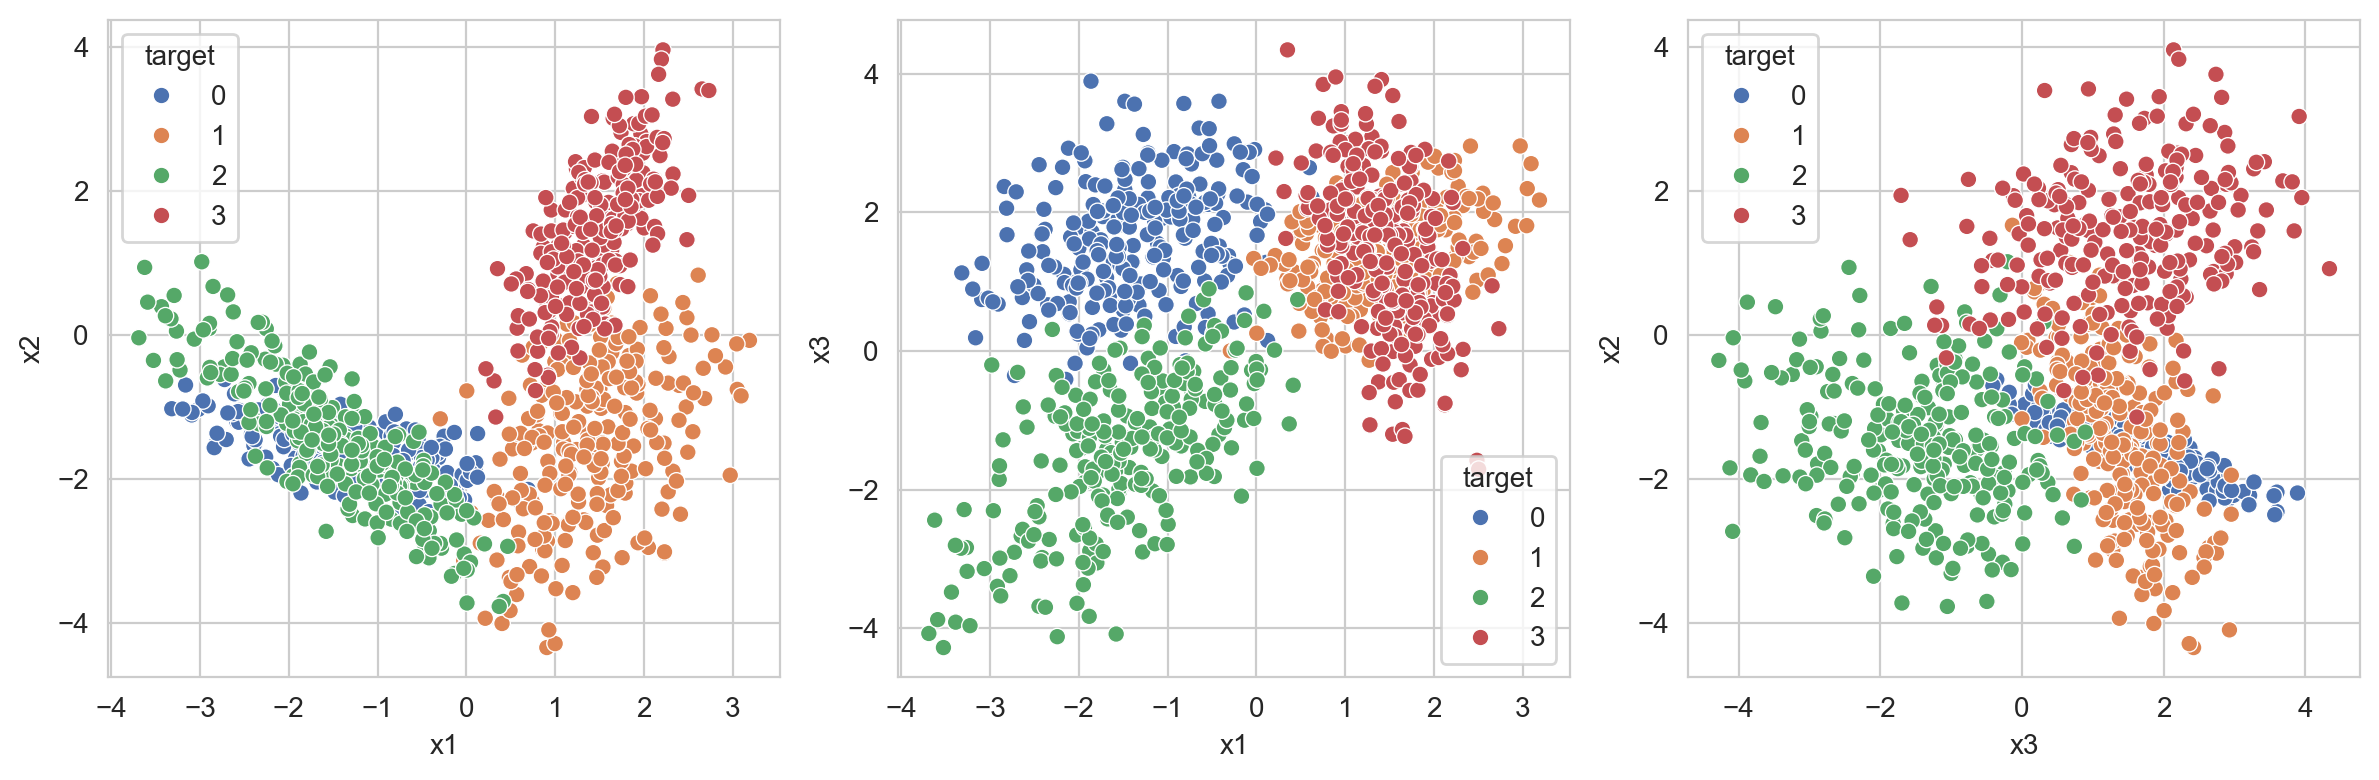

In [1351]:
plt.figure(figsize=(12,4), dpi=200)
plt.subplot(1,3,1)
sns.scatterplot(data=df, x='x1', y='x2', hue=target, palette='deep')
plt.subplot(1,3,2)
sns.scatterplot(data=df, x='x1', y='x3', hue=target, palette='deep')
plt.subplot(1,3,3)
sns.scatterplot(data=df, x='x3', y='x2', hue=target, palette='deep')
plt.tight_layout()
plt.show()

### Correlation matrix

In [1352]:
def correlation_heatmap(df:pd.DataFrame) -> None:
    sns.heatmap(
        data=df.corr().abs(),
        cmap='magma',
        annot=True,
        fmt='.1f',
        annot_kws={'size': 8},
        vmax=1,
        vmin=0,
    )
    plt.title('Correlation matrix')

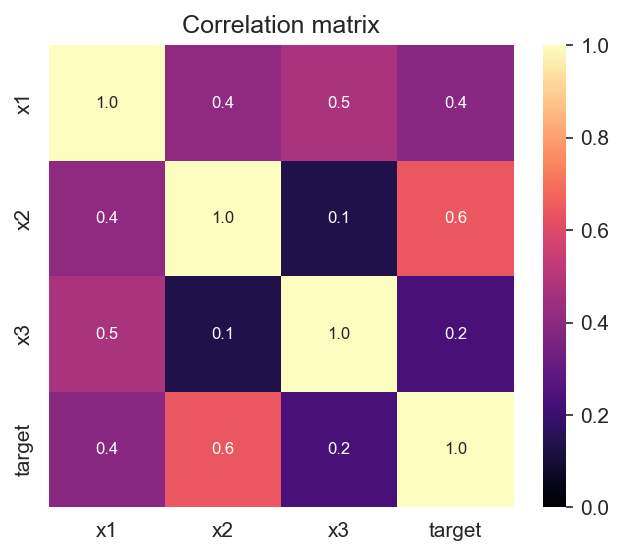

In [1353]:
plt.figure(figsize=(5,4), dpi=150)
correlation_heatmap(df.copy())
plt.show()

**Observation:** X2 has the strongest linear correlation with the target and X3 has the weakest.

### Mutual information

In [1354]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

def mutual_info_target(df:pd.DataFrame, target:str) -> None:

    X = df.loc[:, df.columns != target]
    y = df[target]

    if y.dtype == int:
        mi_scores = pd.Series(mutual_info_classif(X, y), index=X.columns)
    else:
        mi_scores = pd.Series(mutual_info_regression(X, y), index=X.columns)

    sns.barplot(mi_scores.sort_values(ascending=False), palette='deep')
    plt.title(f'Mutual information for {target}')
    plt.xticks(rotation=45)


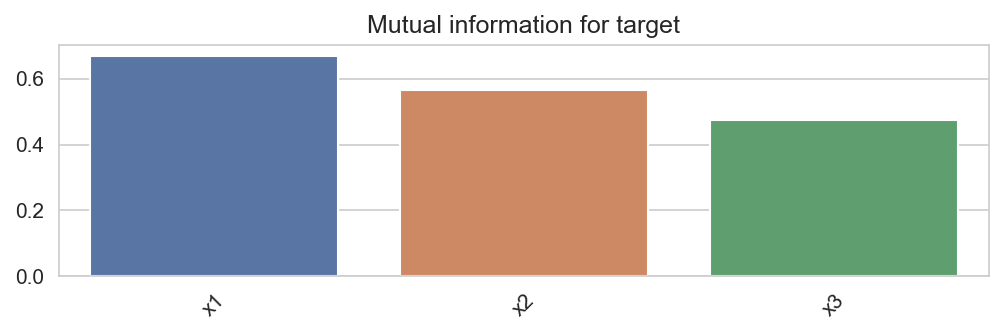

In [1355]:
plt.figure(figsize=(8,2), dpi=150)
mutual_info_target(df.copy(), target)
plt.show()

**Observation:** X1 has the largest MI with the target and X3 has the smallest MI with the target.

# Feature engineering

Split the data into X and y

In [1356]:
X = df.drop(columns=target)
y = df[target].copy()

Split the data into train and test datasets

In [1357]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

### Add some new features

In [1358]:
X_train['x1_squared'] = X_train['x1'] ** 2
X_test['x1_squared'] = X_test['x1'] ** 2

X_train['x2_squared'] = X_train['x2'] ** 2
X_test['x2_squared'] = X_test['x2'] ** 2

X_train['x3_squared'] = X_train['x3'] ** 2
X_test['x3_squared'] = X_test['x3'] ** 2

Update the numerical feature list

In [1359]:
num_features = ['x1', 'x2', 'x3', 'x1_squared', 'x2_squared', 'x3_squared']

### Feature scaling

In [1360]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

Convert the data

In [1361]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Perform one-hot encoding on labels

In [1362]:
def one_hot(y: np.ndarray, num_classes: int) -> np.ndarray:
    return np.eye(num_classes)[y]

In [1363]:
Y_train = one_hot(y_train, target_classes)
Y_test = one_hot(y_test, target_classes)

# Modeling

## Logistic regression using gradient descend

Initialize weights and a bias

In [1364]:
W_g = np.ones((X_train.shape[1], target_classes))
b_g = np.ones((1, target_classes))

Use softmax function

In [1365]:
def softmax(F:np.ndarray) -> np.ndarray:
    Z = np.exp(F)/np.sum(np.exp(F), axis=1, keepdims=True)
    return Z

Predict the target (forward pass)

In [1366]:
def forward_pass(X:np.ndarray, W:np.ndarray, b:np.ndarray=None) -> np.ndarray:
    if b is None:
        Y = softmax(X@W)
    else:
        Y = softmax(X@W + b)
    return Y

Compute Loss function

In [1367]:
def loss_function(Y_hat:np.ndarray, Y_true:np.ndarray, W:np.ndarray=None, r1:float=0, r2:float=0) -> float:
    l = -np.sum(Y_true * np.log(Y_hat + 1e-15))/Y_hat.shape[0]
    if W is not None:
        l += r1 * np.sum(np.power(W,2))/W.size
        l += r2 * np.sum(np.abs(W))/(2*W.size)
    return l

Compute gradients

In [1368]:
def gradients(X:np.ndarray, Y_hat:np.ndarray, Y_true:np.ndarray, W:np.ndarray=None, r1:float=0, r2:float=0):
    gW = (X.T @ (Y_hat - Y_true))/X.shape[0]
    gb =  np.sum(Y_hat-Y_true, axis=0, keepdims=True)/X.shape[0]
    if W is not None:
        gW += r1 * np.sign(W)
        gW += r2 * W
    return gW, gb

Update weights and the bias

In [1369]:
def update_weights(W:np.ndarray,  gW:np.ndarray, b:float, gb:float, lr:float=0.01):
    W -= lr*gW
    b -= lr*gb
    return W, b

Calculate F1-macro

In [1370]:
def f1_macro(y_pred:np.ndarray, y_true:np.ndarray, num_classes:int) -> float:
    f1_scores = []

    for cls in range(num_classes):
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))

        precision = tp / (tp + fp + 1e-15)
        recall = tp / (tp + fn + 1e-15)
        f1 = 2 * precision * recall / (precision + recall + 1e-15)
        f1_scores.append(f1)

    return np.mean(f1_scores)

Loop

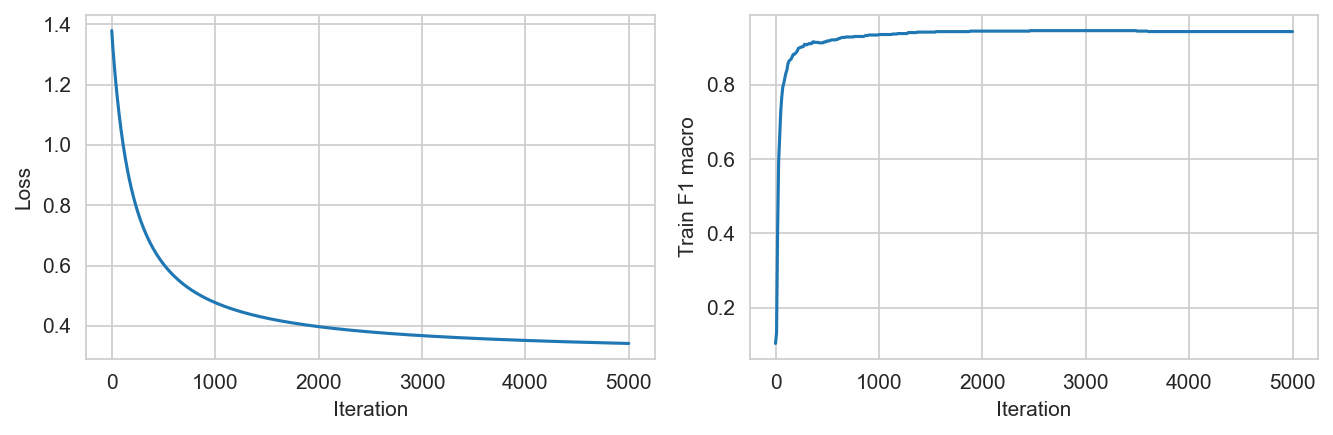

In [1371]:
epochs = 5000
r1, r2 = 0.0001, 0.001
lr0 = 0.3
decay_rate = 0.001
progress = []
score = []

for epoch in range(epochs):
    Y_pred = forward_pass(X_train, W_g, b_g)
    gradW, gradb = gradients(X_train, Y_pred, Y_train, W_g, r1, r2)
    lr = lr0 / (1 + decay_rate * epoch)
    W_g, b_g = update_weights(W_g, gradW, b_g, gradb, lr)
    if epoch%10 == 0:
        Y_pred = forward_pass(X_train, W_g, b_g)
        y_pred = np.argmax(Y_pred, axis=1)
        score.append(f1_macro(y_pred, y_train, target_classes))
        progress.append(loss_function(Y_pred, Y_train, W_g, r1, r2))

plt.figure(figsize=(9,3), dpi=150)
plt.subplot(1,2,1)
plt.plot(np.linspace(0, epochs, len(progress)), progress)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(np.linspace(0, epochs, len(score)), score)
plt.xlabel('Iteration')
plt.ylabel('Train F1 macro')
plt.tight_layout()
plt.show()

Make final prediction

In [1372]:
Y_pred = forward_pass(X_test, W_g, b_g)
y_pred = np.argmax(Y_pred, axis=1)

## Evaluate results

Evaluate result using F1-macro

In [1373]:
f1 = f1_macro(y_pred, y_test, target_classes)

print('F1 Macro using gradient descend:', round(f1, 3))

F1 Macro using gradient descend: 0.97
